
The two loss functions from Kim et al are the same up to a constant factor, sadly.

In [82]:
 from torch.nn.functional import one_hot
 def get_loss_wa(logits, labels):
        """
        get loss from wrong answers
        """

        loss_fn = nn.BCEWithLogitsLoss()
        hot_labels = one_hot(labels, num_classes=5).float()  # (bs,num_choices)
        return loss_fn(logits, hot_labels).item()

def get_loss_ra(logits, labels):
        """
        Run the model and get loss and predictions from right answers
        """
        loss_fn = nn.CrossEntropyLoss()
        return loss_fn(logits, labels).item()


In [83]:
import torch

torch.manual_seed(42)
logits = torch.rand((1000,5))
labels = torch.randint(5,size=(1000,))


In [84]:
get_loss_wa(logits, labels)

0.8817875981330872

In [85]:
get_loss_ra(logits,labels)

1.6390104293823242

In [86]:
torch.manual_seed(42)

all_logits = [(torch.rand(100,5),torch.randint(0,5,size=(100,))) for _ in range(100)]


In [87]:
scores1 = [get_loss_wa(logits,labels) for logits,labels in all_logits]
scores2 =  [get_loss_ra(logits,labels) for logits,labels in all_logits]

In [88]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(dict(scores1=scores1,scores2=scores2))

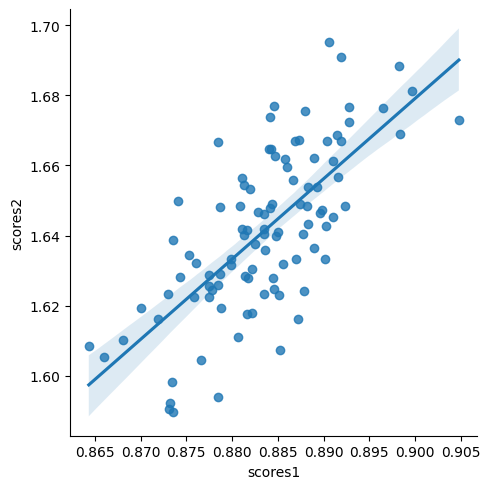

In [89]:
sns.lmplot(data=df,x="scores1",y="scores2")

In [96]:
import statsmodels.api as sm
X = sm.add_constant(scores1)
model = sm.OLS(scores2,X)
results = model.fit(disp=0)

In [97]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     100.4
Date:                Fri, 15 Mar 2024   Prob (F-statistic):           1.10e-16
Time:                        06:32:02   Log-Likelihood:                 270.06
No. Observations:                 100   AIC:                            -536.1
Df Residuals:                      98   BIC:                            -530.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.3796      0.202     -1.882      0.0

In [98]:
results.params

array([-0.3795866 ,  2.28735789])

In [3]:
from datasets import load_dataset

In [4]:
dataset = load_dataset('knowledgator/events_classification_biotech') 

/Users/brewc/PycharmProjects/case_hold_wrong_answers/.venv/lib/python3.10/site-packages/datasets/load.py:1461: FutureWarning: The repository for knowledgator/events_classification_biotech contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/knowledgator/events_classification_biotech
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [5]:
dataset['train'][0]


{'title': "Sarah Polley's Book Recommendations",
 'content': 'Drive Your Plow Over the Bones of The Dead\nby Olga Tokarczuk. I am an incredibly slow reader, but the tone and specificity of the world she creates in this book was something I couldnt leave behind until it was done. Also: All We Sawby Anne Michaels, Fight Nightby Miriam Toews, and The Summer Before the Darkby Doris Lessing.\nId like turned into a Netflix show:\nby Amia Srinivasan. One of the most brain-shattering books Ive ever read. Her thinking is so electrically rigorous and fearless. (I double DARE them to make this into a Netflix show!)\n...I last bought:\n. I rediscovered her poetry lately, and I feel like I dont want to read anything else for a while. She owns desire and submerged things.\n...has the greatest ending:\nby J.D. Salinger. The last page always leaves me breathless. The intimacy and truth of that final page is so arresting and almost painful to read.\nshould be on every college syllabus:\nby Anton Piatig

In [6]:
from transformers import AutoTokenizer,AutoModelForMultipleChoice

ckpt = "distilbert/distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(ckpt)
roberta = AutoModelForMultipleChoice.from_pretrained(ckpt)

Some weights of RobertaForMultipleChoice were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [7]:
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'content', 'target organization', 'all_labels', 'all_labels_concat', 'label 1', 'label 2', 'label 3', 'label 4', 'label 5'],
        num_rows: 2759
    })
    test: Dataset({
        features: ['title', 'content', 'target organization', 'all_labels', 'all_labels_concat', 'label 1', 'label 2', 'label 3', 'label 4', 'label 5'],
        num_rows: 381
    })
})

In [9]:
bat = tokenizer(dataset['train']['content'][0])


In [13]:
dataset['train'][0]

{'title': "Sarah Polley's Book Recommendations",
 'content': 'Drive Your Plow Over the Bones of The Dead\nby Olga Tokarczuk. I am an incredibly slow reader, but the tone and specificity of the world she creates in this book was something I couldnt leave behind until it was done. Also: All We Sawby Anne Michaels, Fight Nightby Miriam Toews, and The Summer Before the Darkby Doris Lessing.\nId like turned into a Netflix show:\nby Amia Srinivasan. One of the most brain-shattering books Ive ever read. Her thinking is so electrically rigorous and fearless. (I double DARE them to make this into a Netflix show!)\n...I last bought:\n. I rediscovered her poetry lately, and I feel like I dont want to read anything else for a while. She owns desire and submerged things.\n...has the greatest ending:\nby J.D. Salinger. The last page always leaves me breathless. The intimacy and truth of that final page is so arresting and almost painful to read.\nshould be on every college syllabus:\nby Anton Piatig

In [2]:
from torch import nn   
   
def get_preds_loss_labels(batch, wrong_answers, model):
        """
        Shared function for training validation and testing.
        :param batch:
        :return:
        """
        labels = batch["labels"]
        logits = model(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        if wrong_answers:
            loss_fn = nn.BCEWithLogitsLoss()
            # reasoning here is to make the positive class "not wrong answer"
            # but still require that wrong answers be driven towards zero.
            labels = nn.functional.one_hot(labels, num_classes=5).float()
            loss = loss_fn(logits, labels)
            preds = (logits.sigmoid() > 0.5).float()  # ??? threshold

        else:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            preds = logits.argmax(dim=1)
        return preds, loss, labels